### Example

# RRCF-Power

## Import and Reshape Data

In [1]:
import pandas as pd
data_source_path = 'rrcf_power/data/sample-1H.csv'
df = pd.read_csv(data_source_path)
df.head()

,Unnamed: 0,date,category,value
0,1,2019-09-01 12:00:00,A,17
1,2,2019-09-01 12:00:00,B,6
2,3,2019-09-01 12:00:00,C,7
3,4,2019-09-01 13:00:00,A,23
4,5,2019-09-01 13:00:00,B,1


## Make Date as Index

In [2]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,Unnamed: 0,category,value
date,,,
2019-09-01 12:00:00,1,A,17
2019-09-01 12:00:00,2,B,6
2019-09-01 12:00:00,3,C,7
2019-09-01 13:00:00,4,A,23
2019-09-01 13:00:00,5,B,1


## Convert to Timeseries

In [3]:
category = df['category'].unique()
df_temp = pd.DataFrame()
for val in category:
    # fetch data from category
    df_temp_temp = df[df['category']==val]['value']
    
    # drop duplicate date
    df_temp[val] = df_temp_temp[~df_temp_temp.index.duplicated(keep='first')]
df = df_temp
df.head()

,A,B,C
2019-09-01 12:00:00,17,6.0,7.0
2019-09-01 13:00:00,23,1.0,6.0
2019-09-01 14:00:00,17,4.0,9.0
2019-09-01 15:00:00,15,5.0,10.0
2019-09-01 16:00:00,15,6.0,9.0


## Resample to Fill Missing Time

In [4]:
df = df.resample('1h').sum() # .sum() make no value in lookup become 0
df.head()

,A,B,C
2019-09-01 12:00:00,17,6.0,7.0
2019-09-01 13:00:00,23,1.0,6.0
2019-09-01 14:00:00,17,4.0,9.0
2019-09-01 15:00:00,15,5.0,10.0
2019-09-01 16:00:00,15,6.0,9.0


## Check for NaN

In [5]:
for col in category:
    print(f'NaN in {col}: {df[col].isnull().any()}')

NaN in A: False
NaN in B: False
NaN in C: False


## Replace NaN to 0

In [6]:
df.fillna(0, inplace=True)

In [7]:
for col in category:
    print(f'NaN in {col}: {df[col].isnull().any()}')

NaN in A: False
NaN in B: False
NaN in C: False


## Plot

In [8]:
import matplotlib.pyplot as plt
import math

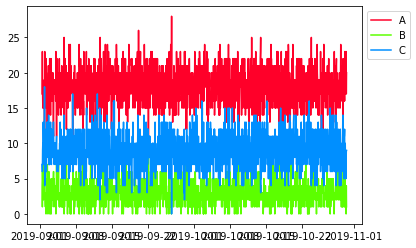

In [9]:
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle('color', [cm(1.*i/len(df.columns)) for i in range(len(df.columns))])
for col_name in df.columns:
    ax.plot(df[col_name])
plt.legend(df.columns, ncol=int(math.ceil(len(df.columns)/10)),  bbox_to_anchor=(1, 1))
plt.show()

## Scaler (Optional, for Data With Very Different Range Value)

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()
scaler.fit(df)
df[df.columns] = scaler.transform(df) # use inverse_transform to reverse
import numpy as np

df.head()

,A,B,C
2019-09-01 12:00:00,0.421053,0.666667,0.388889
2019-09-01 13:00:00,0.736842,0.111111,0.333333
2019-09-01 14:00:00,0.421053,0.444444,0.500000
2019-09-01 15:00:00,0.315789,0.555556,0.555556
2019-09-01 16:00:00,0.315789,0.666667,0.500000


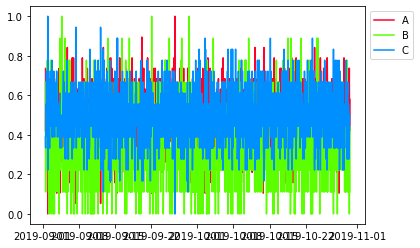

In [12]:
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle('color', [cm(1.*i/len(df.columns)) for i in range(len(df.columns))])
for col_name in df.columns:
    ax.plot(df[col_name])
plt.legend(df.columns, ncol=int(math.ceil(len(df.columns)/10)),  bbox_to_anchor=(1, 1))
plt.show()

## RRCF (Initial)

In [13]:
import numpy as np
X = df.to_numpy()
n_points, n_vars = np.shape(X)
n_points, n_vars

(1419, 3)

In [14]:
np.isnan(X).any()

False

In [15]:
# Seed for Repeatebility
np.random.seed(0)

## RRCF Non-Stream

In [16]:
import rrcf

# Construct forest
forest = []

# Specify forest parameters
num_trees = 100
tree_size = int(n_points * 0.125)
sample_size_range = (n_points // tree_size, tree_size)

while len(forest) < num_trees:
    # Select random subsets of points uniformly from point set
    ixs = np.random.choice(n_points, size=sample_size_range, replace=False)
    
    # Add sampled trees to forest
    trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

In [17]:
# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n_points))
index = np.zeros(n_points)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

In [18]:
anom_idx = (avg_codisp > avg_codisp.quantile(0.99))
anom_idx = anom_idx[anom_idx].index
anom_idx

Int64Index([11, 67, 76, 142, 257, 270, 333, 449, 495, 603, 670, 720, 744, 1018,
            1048],
           dtype='int64')

In [19]:
X[avg_codisp > avg_codisp.quantile(0.99)]

array([[0.        , 0.33333333, 1.        ],
       [0.10526316, 0.88888889, 0.61111111],
       [0.26315789, 1.        , 0.38888889],
       [0.05263158, 0.33333333, 0.94444444],
       [0.05263158, 0.33333333, 0.94444444],
       [0.84210526, 0.33333333, 0.11111111],
       [0.10526316, 0.33333333, 0.88888889],
       [0.89473684, 0.11111111, 0.16666667],
       [0.10526316, 1.        , 0.55555556],
       [1.        , 0.22222222, 0.        ],
       [0.15789474, 1.        , 0.5       ],
       [0.31578947, 0.11111111, 0.77777778],
       [0.10526316, 0.33333333, 0.88888889],
       [0.84210526, 0.22222222, 0.16666667],
       [0.21052632, 0.11111111, 0.88888889]])

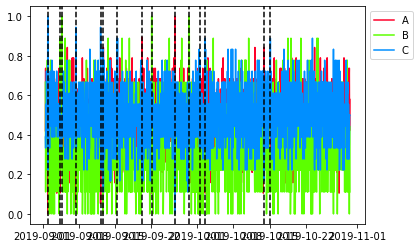

In [20]:
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle('color', [cm(1.*i/len(df.columns)) for i in range(len(df.columns))])

for col_name in df.columns:
    ax.plot(df[col_name])
    
for xc in df.index[anom_idx]:
    plt.axvline(x=xc, color='k', linestyle='--')
    
plt.legend(df.columns, ncol=int(math.ceil(len(df.columns)/10)),  bbox_to_anchor=(1, 1))

plt.show()

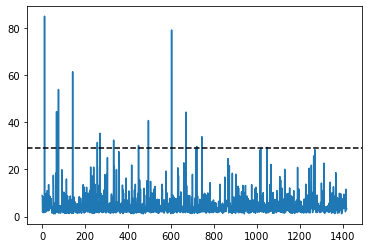

In [21]:
plt.plot(avg_codisp)
plt.axhline(avg_codisp.quantile(0.99), color='k', linestyle='--')
plt.show()

## RRCF Stream

In [22]:
# Set tree parameters
num_trees = 100
n_shingle = 8 # lenght of the shingle, using 8 hour as one point
shingle_size = n_shingle # * n_vars
tree_size = 24 * 5 # number of points in the tree for fifo, hour in a day * days

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

In [23]:
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(X, size=n_shingle)

In [24]:
# transpose
def shingle_transpose(shingle):
    for val in shingle:
        yield val.T.flatten()

points = shingle_transpose(points)

In [25]:
# Create a dict to store anomaly score of each point
avg_codisp = pd.Series(0.0, index=np.arange(n_points + 1 - shingle_size))

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size...
        if len(tree.leaves) > tree_size:
            # Drop the oldest point (FIFO)
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point...
        new_codisp = tree.codisp(index)
        # And take the average over all trees
        avg_codisp[index] += new_codisp / num_trees

In [26]:
anom_idx = (avg_codisp > avg_codisp.quantile(0.99))
anom_idx = anom_idx[anom_idx].index
anom_idx

Int64Index([102, 125, 131, 137, 172, 270, 288, 294, 295, 449, 476, 494, 601,
            603, 663],
           dtype='int64')

In [27]:
# create anom region
def shingle_index_to_range(index, shingle_size):
    return index, [i + shingle_size for i in index] # left_index, rigth_index

def range_to_time_index(left_index, right_index):
#     '''In reading time_index, please ignore the rightmost value of each batch.'''
    time_index = []
    for left, right in zip(left_index, right_index):
        for val in range(left, right):
            if val not in time_index:
                time_index.append(val)
    return time_index

def merge_region(time_index):
    pointer = 0
    left_i = time_index[pointer]
    merged_region = []
    while pointer <= len(time_index):
        counter = 0
        for right_i in time_index[pointer::]:
            if right_i > left_i + counter:
                pointer -= 1
                break
            pointer += 1
            counter += 1
        if pointer >= len(time_index):
            pointer -= 1
            merged_region.append([left_i, time_index[pointer]])
            break
        merged_region.append([left_i, time_index[pointer]])
        left_i = time_index[pointer + 1]
    return merged_region

def get_anomaly_region(index, shingle_size):
    left, right = shingle_index_to_range(index, shingle_size)
    time_index = range_to_time_index(left, right)
    return merge_region(time_index)

anom_regions = get_anomaly_region(anom_idx, shingle_size)
anom_regions

[[102, 109],
 [125, 144],
 [172, 179],
 [270, 277],
 [288, 302],
 [449, 456],
 [476, 483],
 [494, 501],
 [601, 610],
 [663, 670]]

In [32]:
import copy
def correct_index(anom_regions, shingle_size):
    anom_regions_copy = copy.deepcopy(anom_regions)
    for idx, val in enumerate(anom_regions_copy):
        if isinstance(val, list):
            val = correct_index(val, shingle_size)
        else:
            val += shingle_size - 1 # shift = shingle_size - 1
        anom_regions_copy[idx] =  val
    return anom_regions_copy
anom_regions_shifted = correct_index(anom_regions, shingle_size)
anom_regions_shifted

[[109, 116],
 [132, 151],
 [179, 186],
 [277, 284],
 [295, 309],
 [456, 463],
 [483, 490],
 [501, 508],
 [608, 617],
 [670, 677]]

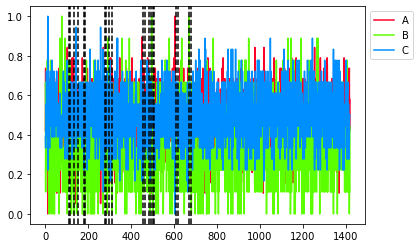

In [43]:
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle('color', [cm(1.*i/len(df.columns)) for i in range(len(df.columns))])

plt.plot(X)

VERTICAL_DASH = 'black' # choose 'rainbow' or 'black', rainbow is better to marking different regions
if VERTICAL_DASH == 'rainbow':
    colors = [cm(1.*i/len(anom_regions_shifted)) for i in range(len(anom_regions_shifted))]
    for idx, anom_region in enumerate(anom_regions_shifted):
        plt.axvline(x=anom_region[0], color=colors[idx], linestyle='--')
        plt.axvline(x=anom_region[1], color=colors[idx], linestyle='--')

elif VERTICAL_DASH == 'black':
    for idx, anom_region in enumerate(anom_regions_shifted):
        plt.axvline(x=anom_region[0], color='k', linestyle='--')
        plt.axvline(x=anom_region[1], color='k', linestyle='--')
    
plt.legend(df.columns, ncol=int(math.ceil(len(df.columns)/10)),  bbox_to_anchor=(1, 1))

plt.show()

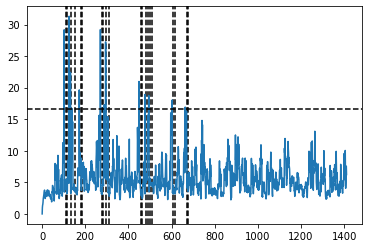

In [44]:
if VERTICAL_DASH == 'rainbow':
    for idx, anom_region in enumerate(anom_regions_shifted):
        plt.axvline(x=anom_region[0], color=colors[idx], linestyle='--')
        plt.axvline(x=anom_region[1], color=colors[idx], linestyle='--')
elif VERTICAL_DASH == 'black':
    for idx, anom_region in enumerate(anom_regions_shifted): # comment to remove black line mark
        plt.axvline(x=anom_region[0], color='k', linestyle='--')
        plt.axvline(x=anom_region[1], color='k', linestyle='--')
        
plt.plot(avg_codisp)
plt.axhline(avg_codisp.quantile(0.99), color='k', linestyle='--')
plt.show()

## save model

In [30]:
# import dill as pickle
# import json
# import os
# import os.path as osp
# folder_result = 'rrcf_power/data/result/'
# file_label = ''
# if not osp.exists(folder_result):
#     os.makedirs(folder_result)
# params = {
#     'num_trees': num_trees,
#     'shingle_size': shingle_size, # five minutes
#     'tree_size': tree_size, # number of points in the tree for fifo, minutes in a day
#     'data_source_path': data_source_path
# }
# pickle.dump(forest, open(osp.join(folder_result,'forest'+file_label+'.pickle'), 'wb'))
# pickle.dump(avg_codisp, open(osp.join(folder_result,'avg_codispt'+file_label+'.pickle'), 'wb'))
# json.dump(params, open(osp.join(folder_result,'params'+file_label+'.json'), 'w'))